In [1]:
#import some necessary librairies

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
%matplotlib inline
import matplotlib.pyplot as plt  # Matlab-style plotting
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)
warnings.warn_explicit = ignore_warn

import pickle
from scipy import stats
from scipy.stats import norm, skew #for some statistics

pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points

from keras.callbacks import ModelCheckpoint, History, EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from keras.metrics import RootMeanSquaredError, MeanSquaredError
from matplotlib import pyplot as plt
import keras_tuner as kt

# Daten aus vorigem Schritt laden

In [2]:
with open('../data/house-prices-advanced-regression-techniques/x_preprocessed_train.pkl', 'rb') as handle:
    X_preprocessed_train = pickle.load(handle)

with open('../data/house-prices-advanced-regression-techniques/y_train.pkl', 'rb') as handle:
    y_preprocessed_train = pickle.load(handle)
    
with open('../data/house-prices-advanced-regression-techniques/x_test.pkl', 'rb') as handle:
    X_preprocessed_test = pickle.load(handle)


# Train Test Split

In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score

# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
seed = 4354 # Random_state ist ein seed, damit gegebenenfalls immer mit der selben pseudo Random Folge gearbeitet wird.
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed_train, y_preprocessed_train, test_size=0.2, random_state=seed) 


In [4]:
from keras_tuner import HyperParameters as hp

In [5]:
# see https://www.tensorflow.org/tutorials/keras/keras_tuner
def model_builder(hp):
    model = Sequential()
    # The Input Layer :
    model.add(Dense(hp.Choice('units1', [32, 64, 128, 256]), kernel_initializer='normal',input_dim = X_train.shape[1], activation='relu'))
    
    # The Hidden Layers :
    model.add(Dense(hp.Choice('units2', [32, 64, 128, 256, 1024]), kernel_initializer='normal',activation='relu'))
    model.add(Dense(hp.Choice('units3', [32, 64, 128, 256, 1024]), kernel_initializer='normal',activation='relu'))
    model.add(Dense(hp.Choice('units4', [32, 64, 128, 256, 1024]), kernel_initializer='normal',activation='relu'))    
    # The Output Layer :
    model.add(Dense(1, kernel_initializer='normal',activation='linear'))

    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    # Compile the network :
    model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=hp_learning_rate), metrics=[MeanSquaredError()])
    return model

In [6]:
tuner = kt.Hyperband(model_builder,
                     objective='mean_squared_error',
                     max_epochs=20,
                     factor=3,
                     directory='tuner_dir',
                     project_name='tune deep house prices')

Reloading Tuner from tuner_dir\tune deep house prices\tuner0.json


In [7]:
stop_early = EarlyStopping(monitor='val_loss', patience=5)

In [8]:
tuner.search(X_train, y_train, epochs=50, validation_split=0.2, callbacks=[stop_early])

In [9]:
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete.
The optimal number of units in the first densely-connected layer is {best_hps.get('units1')}.
The optimal number of units in the second densely-connected layer is {best_hps.get('units2')}.
The optimal number of units in the third densely-connected layer is {best_hps.get('units3')}.
The optimal number of units in the fourth densely-connected layer is {best_hps.get('units4')}.
The optimal learning_rate for Adam is {best_hps.get('learning_rate')}.

""")


The hyperparameter search is complete.
The optimal number of units in the first densely-connected layer is 64.
The optimal number of units in the second densely-connected layer is 128.
The optimal number of units in the third densely-connected layer is 64.
The optimal number of units in the fourth densely-connected layer is 1024.
The optimal learning_rate for Adam is 0.01.




In [10]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner.hypermodel.build(best_hps)

In [11]:
#checkpoint_name = 'Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 
checkpoint_name = 'model.weights.best.hdf5'
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
history = History()
callbacks_list = [checkpoint, history]

In [12]:
result = model.fit(X_train, y_train, epochs=500, batch_size=32, validation_split = 0.2, callbacks=callbacks_list)


Epoch 1/500
 1/30 [>.............................] - ETA: 8s - loss: 146.7842 - mean_squared_error: 146.7842
Epoch 1: val_loss improved from inf to 6.42915, saving model to model.weights.best.hdf5
30/30 [==============================] - 1s 8ms/step - loss: 78.1562 - mean_squared_error: 78.1562 - val_loss: 6.4292 - val_mean_squared_error: 6.4292
Epoch 2/500
 1/30 [>.............................] - ETA: 0s - loss: 5.5891 - mean_squared_error: 5.5891
Epoch 2: val_loss improved from 6.42915 to 0.74799, saving model to model.weights.best.hdf5
30/30 [==============================] - 0s 3ms/step - loss: 2.6343 - mean_squared_error: 2.6343 - val_loss: 0.7480 - val_mean_squared_error: 0.7480
Epoch 3/500
 1/30 [>.............................] - ETA: 0s - loss: 0.7507 - mean_squared_error: 0.7507
Epoch 3: val_loss improved from 0.74799 to 0.18469, saving model to model.weights.best.hdf5
30/30 [==============================] - 0s 3ms/step - loss: 0.2671 - mean_squared_error: 0.2671 - val_loss: 

In [13]:
history.history['mean_squared_error']

[78.15619659423828,
 2.6343064308166504,
 0.26712489128112793,
 0.10397613793611526,
 0.07540229707956314,
 0.04236205294728279,
 0.032412830740213394,
 0.02555810660123825,
 0.019352875649929047,
 0.019053079187870026,
 0.016671229153871536,
 0.014829742722213268,
 0.012550712563097477,
 0.012423730455338955,
 0.01271012518554926,
 0.013344723731279373,
 0.017609307542443275,
 0.021802715957164764,
 0.021096348762512207,
 0.02547307312488556,
 0.016233962029218674,
 0.01463253516703844,
 0.011849777773022652,
 0.011085286736488342,
 0.01075891125947237,
 0.011706535704433918,
 0.010310828685760498,
 0.010717175900936127,
 0.03327189013361931,
 0.023676671087741852,
 0.018837330862879753,
 0.014881392940878868,
 0.019029326736927032,
 0.027234885841608047,
 0.015545360743999481,
 0.012743435800075531,
 0.01393524743616581,
 0.01227558869868517,
 0.014056732878088951,
 0.011289922520518303,
 0.012516332790255547,
 0.021282073110342026,
 0.018362194299697876,
 0.01735520176589489,
 0.018

In [14]:
root_mean_squared_error = np.sqrt(result.history['mean_squared_error'])
val_root_mean_squared_error = np.sqrt(result.history['val_mean_squared_error'])

best_epoch = list (val_root_mean_squared_error).index(min(val_root_mean_squared_error)) + 1
print('Best epoch: %d' % (best_epoch,))
print (f'Best RMSE: {min(val_root_mean_squared_error)}')

Best epoch: 319
Best RMSE: 0.11332903873438674


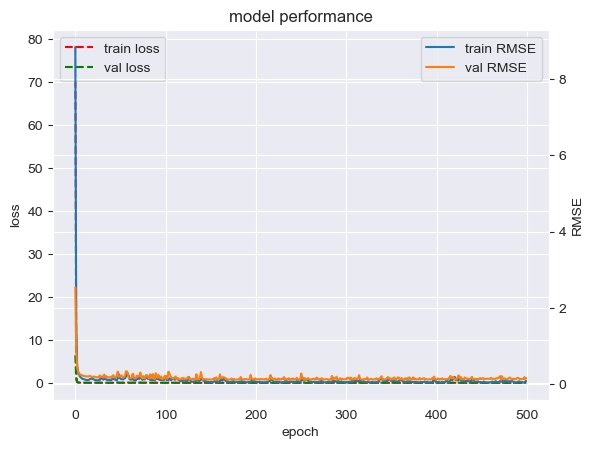

In [15]:
fig, ax1 = plt.subplots()
ax1.plot(history.history['loss'], color='red', linestyle='--')
ax1.plot(history.history['val_loss'], color='green', linestyle='--')
plt.title('model performance')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'val loss', 'train RMSE', 'varl RMSE'], loc='upper left')

ax2 = ax1.twinx()

ax2.plot(root_mean_squared_error)
ax2.plot(val_root_mean_squared_error)
ax2.set_ylabel('RMSE')
ax2.legend(['train RMSE', 'val RMSE'], loc='upper right')

In [16]:
# Load the weights with the best validation accuracy
model.load_weights('model.weights.best.hdf5')

In [17]:
# Evaluate the model on test set
score = model.evaluate(X_test, y_test, verbose=0)

# Print test RMSE
print('\n', 'Test RMSE:', np.sqrt(score[1]))


 Test RMSE: 0.11858616070217773


In [18]:
model.metrics_names 

['loss', 'mean_squared_error']

In [19]:
y_hat = model.predict(X_test)
y_hat = y_hat.reshape(y_hat.shape[0])

10/10 [==============================] - 0s 1ms/step


In [20]:
rand_vals=np.random.choice(X_test.shape[0], size=15, replace=False)
rand_vals

array([172, 252, 288, 259,  94,  71,  38,  97,   8,  99, 109, 286,   7,
       230, 197])

In [21]:
for i, index in enumerate(rand_vals):
    predict_index = y_hat[index]
    true_index = y_test.to_numpy()[index]
    print (f'{index}: predict={predict_index} / true={true_index}')

172: predict=11.879438400268555 / true=11.849404844423074
252: predict=11.892304420471191 / true=11.849404844423074
288: predict=12.400896072387695 / true=12.373707715234994
259: predict=12.281092643737793 / true=12.445093483000798
94: predict=11.82100772857666 / true=11.695255355062795
71: predict=11.888033866882324 / true=11.904974309480183
38: predict=12.204192161560059 / true=12.242891437918386
97: predict=12.555480003356934 / true=12.631343648903034
8: predict=11.76099681854248 / true=11.715874472198905
99: predict=11.938748359680176 / true=11.964007453736912
109: predict=11.88321590423584 / true=11.97603664577121
286: predict=11.662081718444824 / true=11.608244735642321
7: predict=11.3983736038208 / true=11.302216779257382
230: predict=12.008323669433594 / true=12.128116509451258
197: predict=12.806427955627441 / true=12.75130259456002


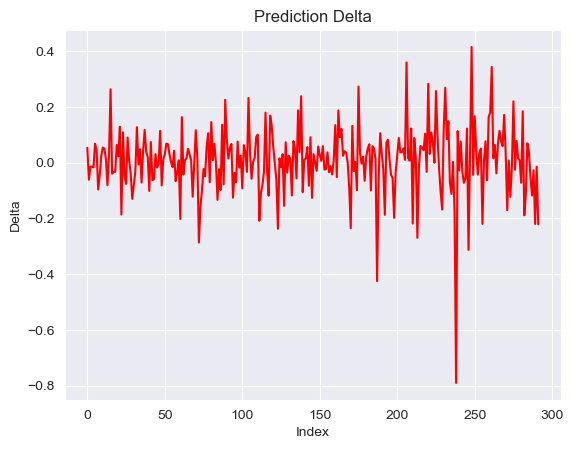

In [22]:
fig, ax1 = plt.subplots()
plt.title('Prediction Delta')
plt.ylabel('Delta')
plt.xlabel('Index')
ax1.plot(np.subtract(y_test.to_numpy(),y_hat), color='red', linestyle='-')

# Weitere Optimierungsmöglichkeiten
## GPU Support

https://lifewithdata.com/2022/01/16/how-to-install-tensorflow-and-keras-with-gpu-support-on-windows/

## Anregungen zur Hyperparameter-Suche

https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/

## Keras Tuner Dokumentation

https://keras.io/api/keras_tuner/